In [4]:
#creating training set data
import torch

torch.manual_seed(0) #random numbers will be the same everytime so that this is reproductible
observations = 2048
train_data = torch.zeros((observations,2)) #creation of 2D tensor with 2048 rows and two collumn (x,y)
train_data[:,0]=50*torch.rand(observations) #[:,0] = first collumn and means that a random number between 0 and 1 will be
                              #chosen and multiplied by 50 to be added in the collumn
train_data[:,1]= 1.08**train_data[:,0] #1.08 because the exercise had 8% so we multiphy that by the value of the first
                              #collumn as the function is y = (1.08)^x



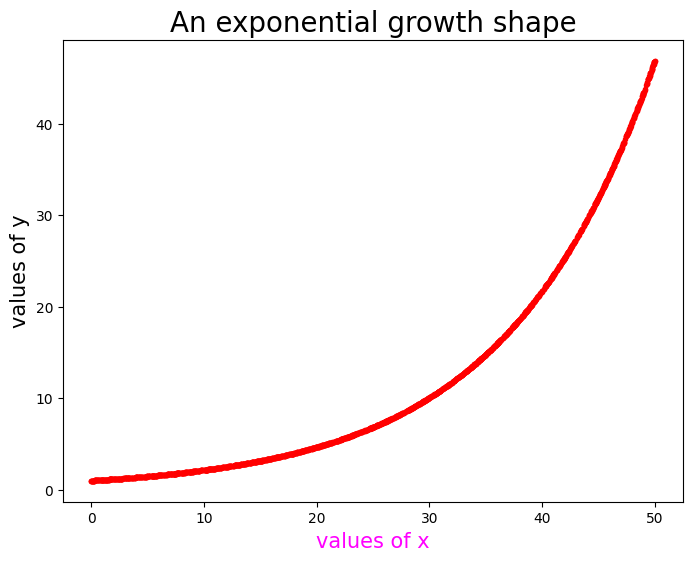

In [5]:
#plotting theexponential curve
import matplotlib.pyplot as plt

fig = plt.figure(dpi = 100, figsize= (8,6)) #dpi is for the resolution
plt.plot(train_data[:,0], train_data[:,1], ".", c="r") # we put the characteristics of the graph that we are doing
                              #(x axis, y axis, we want dots for how the data will be plotted and r is for the color red)
plt.xlabel("values of x", fontsize = 15, color=( 1,0,1,1))
plt.ylabel("values of y", fontsize= 15)
plt.title("An exponential growth shape", fontsize= 20)
plt.show()

In [6]:
#creating train loader from dataset
from torch.utils.data import DataLoader #data loader will handle the train_data tensor in mini batches

batch_size = 128 #during training, the dataset will be divided into groups of 128 samples at a time
train_loader = DataLoader (
    train_data, #it is the input of the loader
    batch_size = batch_size,
    shuffle = True #teh data in randomly shuffle before each epoch so that the model doesn't learn patters
)

batch0= next(iter(train_loader))#putting the data into a 2D tensor of batch_size row and two collum
print(batch0.shape)
print(batch0)

torch.Size([128, 2])
tensor([[41.9333, 25.2099],
        [ 8.0561,  1.8589],
        [22.2487,  5.5416],
        [49.9585, 46.7522],
        [ 8.7647,  1.9631],
        [ 3.0979,  1.2692],
        [26.0517,  7.4259],
        [38.2393, 18.9716],
        [37.1300, 17.4191],
        [45.0543, 32.0541],
        [ 8.7989,  1.9683],
        [20.4796,  4.8362],
        [46.7506, 36.5243],
        [21.8242,  5.3635],
        [11.2329,  2.3738],
        [40.3307, 22.2845],
        [47.0477, 37.3691],
        [47.6369, 39.1026],
        [16.2331,  3.4880],
        [11.7535,  2.4709],
        [12.8855,  2.6958],
        [20.6749,  4.9095],
        [ 4.6602,  1.4314],
        [26.3385,  7.5916],
        [31.7039, 11.4727],
        [45.5565, 33.3172],
        [41.3369, 24.0788],
        [26.8584,  7.9015],
        [14.9879,  3.1692],
        [33.7039, 13.3817],
        [47.7350, 39.3988],
        [31.7714, 11.5324],
        [ 7.4853,  1.7790],
        [14.5973,  3.0754],
        [31.4056, 11.2122],

In [7]:
#Structuring the discrimator and generator models
import torch.nn as nn
#discriminator takes an input, real or fake data from teh generator and output a proba between 0 and 1 that indicates real or fake (higher it is the realest it is)
D=nn.Sequential(
     #creating the discriminator that tries to distinguish between the real an fake sample
  nn.Linear(2, 256), #takes two inputs and projects 256 neurons
  nn.ReLU(), #non linerarity that helps the network learn complex patterns
  nn.Dropout(0.3), #randomly drops 30% of neurons during training to prevent overfitting
  nn.Linear(256,128), #we reduce from 256 neurons to 128 neurons
  nn.ReLU(),
  nn.Dropout(0.3),
  nn.Linear(128,64),
  nn.ReLU(),
  nn.Dropout(0.3),
  nn.Linear(64,1),
  nn.Sigmoid() #ensures that the output is between 0 and 1
                 )
#generator
G = nn.Sequential( #genrate random noise to create a fake sample
    nn.Linear(2,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)
)


In [8]:
#the loss function and optimizer
#loss measures how wrong a network's predictions are
loss_fn=nn.BCELoss() #discriminator's loss, if its low it means that the discriminator is correct
              #high means it's being fooled
lr = 0.0005 #learning rate
optimD = torch.optim.Adam(D.parameters(), lr=lr)
optimG = torch.optim.Adam(G.parameters(), lr=lr) #optimizer that updates the network's weights using gradients

In [9]:
#Calculate Mean Square Error
mse = nn.MSELoss() #generator's loss, if high it means that the generator is doing a good job so we want it as low as possible
def performance(fake_samples):
  real = 1.08**fake_samples[:,0]
  mseloss=mse(fake_samples[:,1], real)
  return mseloss


In [10]:
# the early stop class
#it stops training automatically when there's no more progress
class EarlyStop:
  def __init__(self, patience=1000):
    self.patience = patience #how many steps to wait before stopping
    self.steps = 0 #counter of how many times we saw no improvement
    self.min_gdif = float('inf') #best loss seen so far and we start with a high number, gdif is loss value
  def stop(self, gdif):
    if gdif < self.min_gdif: #there is an improvement
      self.min_gdif = gdif #we update the counter
      self.steps = 0 #we reset the counter
    elif gdif >= self.min_gdif:
      self.steps += 1 #no improvement
    if self.steps >= self.patience:
      return True #stops training
    else:
      return False


In [11]:
#creating labels
#used by the BCE loss to train the disciminator
real_labels= torch.ones((batch_size, 1)) #creates a tensor of 1s to tell the disciminator that
                          #these are real samples
real_labels = real_labels

fake_labels=torch.zeros((batch_size, 1)) #creates a tensor of 0s to tell the disciminator that
                          #these are fake samples
fake_labels=fake_labels

In [12]:
#Training discriminator on real data
#train the discriminator on real data only
def train_D_on_real(real_samples):
  real_samples= real_samples #batch of real data from the dataset
  optimD.zero_grad() #clear out old gradients stored in the optimizer (otherwise it will accumulate)
  out_D=D(real_samples) #pass the real data through the discriminator model
                #out_D = values between 0 and 1, proba that the input is real
  loss_D = loss_fn(out_D, real_labels) #compute the BCEloss, compares the proba value and tensor of 1s
                #the goal is to have a out_D as close as 1 as possible
  loss_D.backward() #backpropagation to compute gradients of the loss with respect to D's weight
                #D now knows how it should change to reduce the loss
  optimD.step() #actual learning step. uses the optimizer to update the weights oof D using the gradient
  return loss_D #return the loss value so you can monitor how well D is learning on real data

In [13]:
#training discriminator on fake data
def train_D_on_fake(): #BCEloss
  noise = torch.randn((batch_size,2)) #create a radom noise that is going to be used as an
                #input by the generator to make the fake data
  noise= noise
  fake_sample = G(noise) #send the noise into the generator and creates the fake data
  optimD.zero_grad() #clear out old gradients stored in the optimizer
  out_D = D(fake_sample) #pass the fake samples into the discriminator
  loss_D = loss_fn(out_D, fake_labels) #we compare the output of the D's predictions and the tensors of 0s
                #so loss will produce a sigle number thats says how wrong the predictions were
  loss_D.backward() #backpropagation to calculate how to change D's weights to improve its classification on fakes
  optimD.step() #update D's weights with the computed gradient (D learns to be better at detecting fakes)
  return loss_D

In [14]:
#training the generator
def train_G():
  noise = torch.randn((batch_size,2)) #create a radom noise that is going to be used as an
                #input by the generator to make the fake data
  noise= noise
  fake_samples = G(noise) #pass the noise through the generator and it produces the fake sample
  optimG.zero_grad() #clear out old gradients stored in the optimizer
  out_G = D(fake_samples) #we want to know what does the discriminator think about the fake sample
  loss_G = loss_fn(out_G, real_labels) #we compare what the discriminator thought versus the real labels
                    #(tensor of 1s). loss will produce a single number that shows how well the generator fooled the discriminator
  loss_G.backward() #backpropagation to compute the gradients to see how G should adjust it's weight (to try to better fool D next time)
  optimG.step() #updates G's weights
  return loss_G, fake_samples

In [15]:
#test epoch function
import os
os.makedirs("files", exist_ok=True) #creating a folder where the images will be saved
def test_epoch(epoch, gloss, dloss, n, fake_samples): #epoch = which training roung we are on
                  #n = nember used to average the loss
  if epoch == 0 or (epoch+1) % 25 ==0: #run this code when epoch is 0 or every 25 epoch after that
    g = gloss.item()/n #item is to get a raw number from a tensor
                  #and we divide to average it
    d = dloss.item()/n
    print(f"at epoch {epoch+1}, G loss: {g}, D loss: {d}") #print teh current losses
    fake = fake = fake_samples.detach().cpu().numpy() #converts pytorch tensors to nympy arrays, detech remove the tensor from the computation graph
                  #cpu movis it to cpu, numpy converts it into a numpy array
    plt.figure(dpi=200)
    plt.plot(fake[:,0], fake[:,1], "*", c="g", label= "generated samples") #x and y coordinates, * is the marker shape, g is for green
    plt.plot(train_data[:,0], train_data[:,1], ".", c="r", alpha = 0.1, label= "real samples") #alpha is the transparency
    plt.title(f"epoch{epoch+1}") #pour montrer a quel iteration on est
    plt.xlim(0,50) #x axis limit, here from 0 to 50
    plt.ylim(0,50)
    plt.legend()

    plt.savefig(f"files/p{epoch+1}.png") #saves the different epochs
    plt.show()

In [16]:
#creating a stooper class
class Stopper:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best = float('inf')

    def stop(self, value):
        if value < self.best:
            self.best = value
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience


at epoch 1, G loss: 1.4795332590738932, D loss: 0.9867410024007162


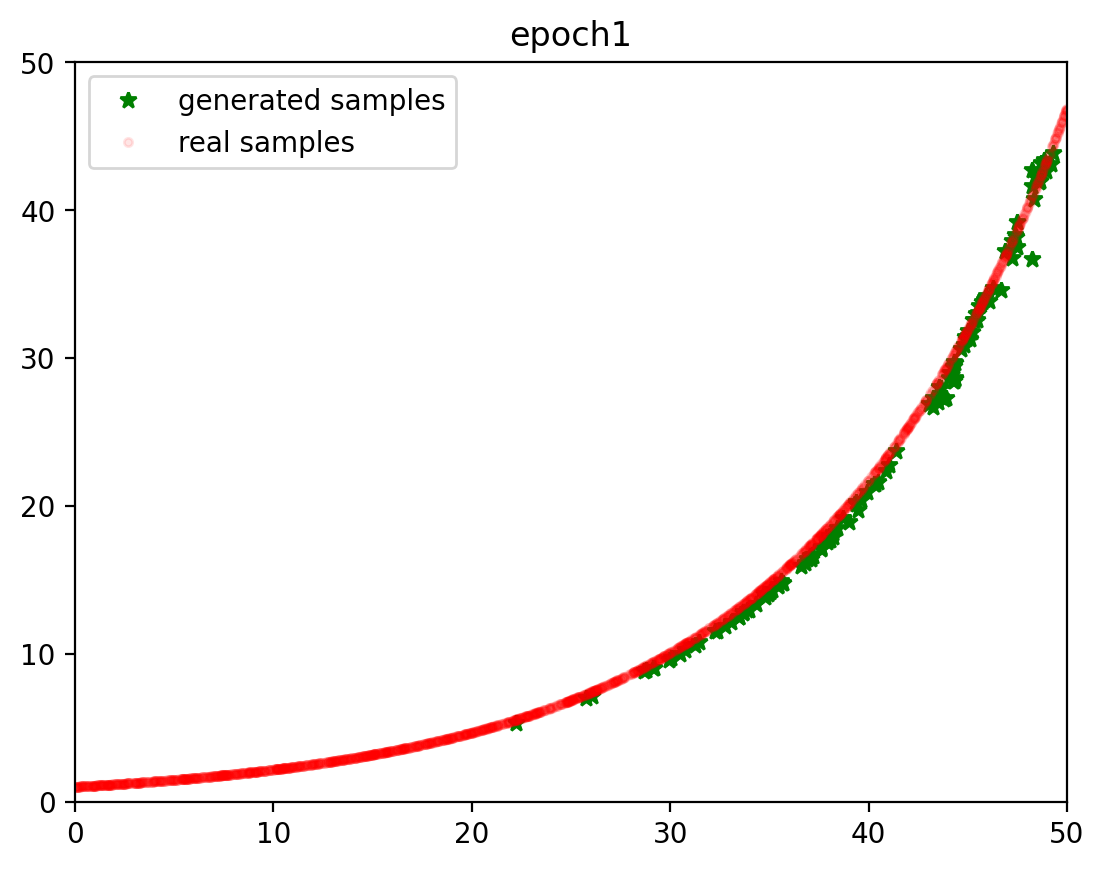

at epoch 25, G loss: 1.3854239145914713, D loss: 0.9466496149698893


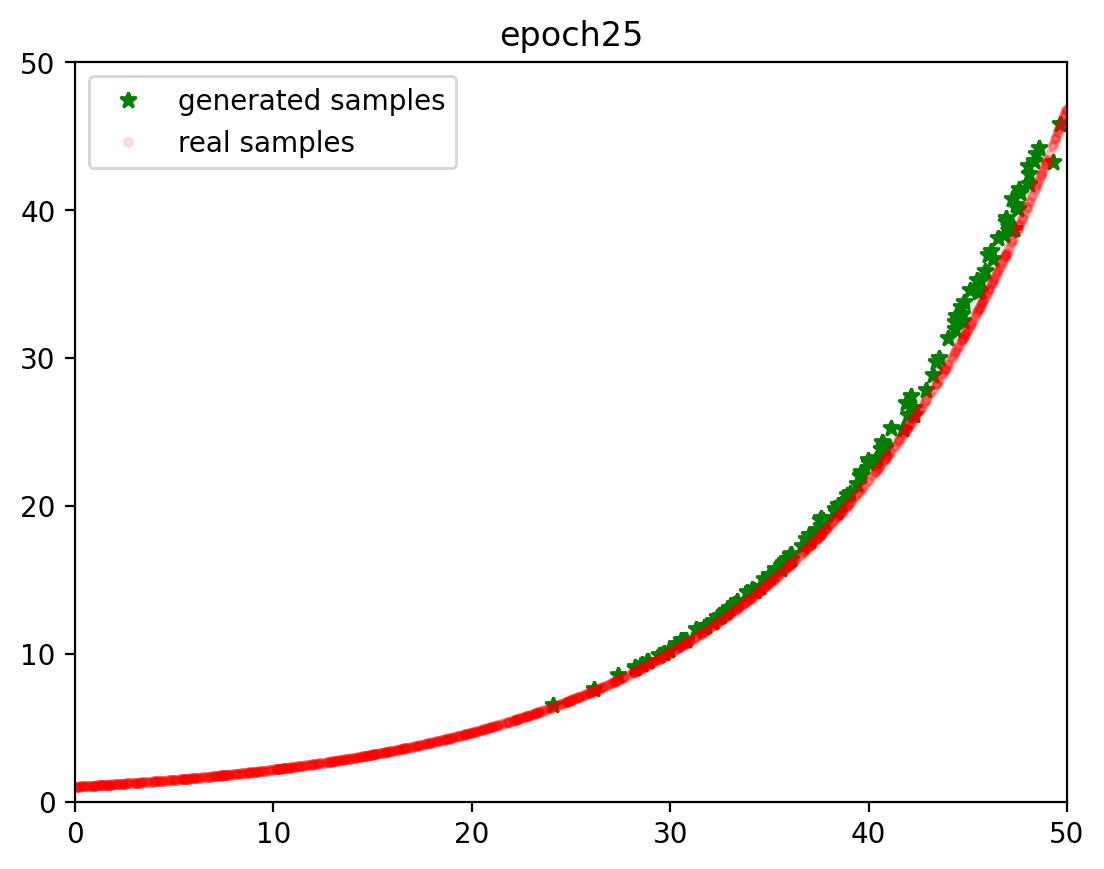

at epoch 50, G loss: 1.2042090098063152, D loss: 0.9875614166259765


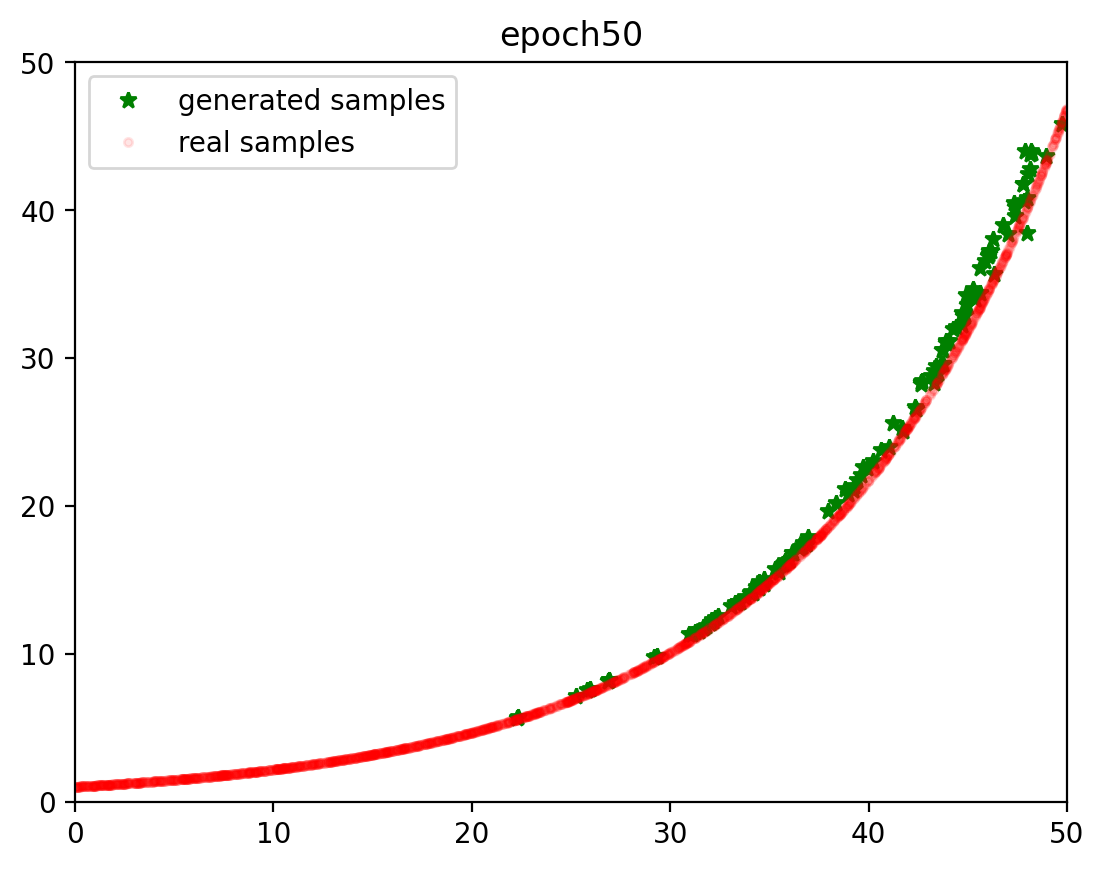

at epoch 75, G loss: 1.5561498006184895, D loss: 0.9043364842732747


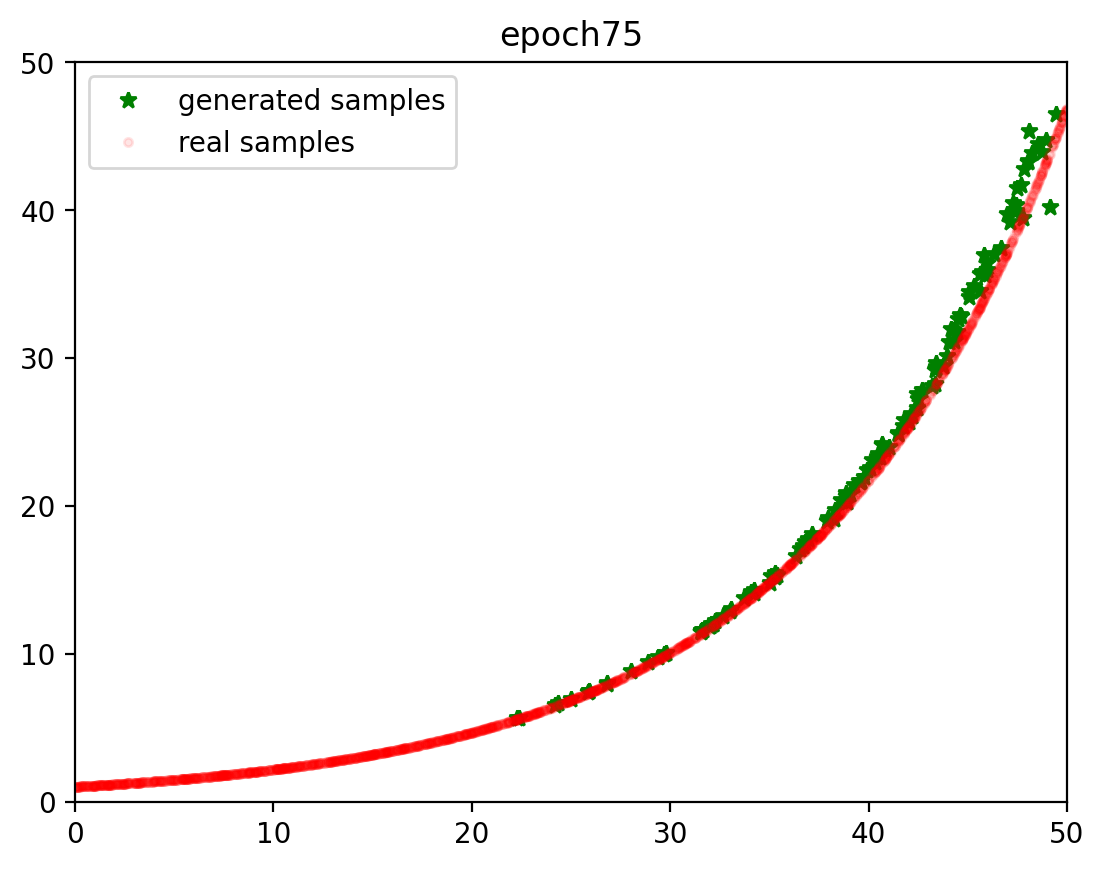

In [22]:
#creating epochs
stopper= Stopper(patience = 50)
for epoch in range (1000):
  gloss = 0
  dloss = 0
  for n, real_samples in enumerate(train_loader):
    loss_D = train_D_on_real(real_samples) #pass real sample throught the discriminator
    dloss+=loss_D
    loss_D=train_D_on_fake() #training the discriminator on the fake data
    dloss+= loss_D
    loss_G, fake_samples=train_G() #training the generator
    gloss+= loss_G
  test_epoch(epoch, gloss, dloss, n, fake_samples)
  gdif=performance(fake_samples).item() #calculates the MSE between the generated samples to the expected
            #values, item changes the tensor into a scalor
  if stopper.stop(gdif)== True: #if the performance has stopped improving the training stops
    break